# Baseline using text similarity and LightGBM

Simple baseline using sentence transformer model to compute similarity between summary and texts. Then using LightGBM to predict from similarity scores and texts size features.

In [19]:
from pathlib import Path 
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [3]:
datapath = Path("../data/")

train_pro = pd.read_csv(datapath / "prompts_train.csv")
train_sum = pd.read_csv(datapath / "summaries_train.csv")

In [4]:
text_emb = {pid: emb for pid,emb in zip(train_pro.prompt_id.values, model.encode(train_pro.prompt_text.values))}
question_emb = {pid: emb for pid,emb in zip(train_pro.prompt_id.values, model.encode(train_pro.prompt_question.values))}

In [5]:
sum_emb = {sid: emb for sid,emb in zip(train_sum.student_id.values, model.encode(train_sum.text.values))}

In [6]:
cossim = {}
for k in text_emb.keys():
    cossim[k] = cosine_similarity(text_emb[k].reshape(1,-1), question_emb[k].reshape(1,-1))[0][0]

In [7]:
cs_text = []
cs_question = []
for sid, pid in train_sum[["student_id","prompt_id"]].values:
    cs_text.append(
        cosine_similarity(text_emb[pid].reshape(1,-1), sum_emb[sid].reshape(1,-1))[0][0]
    )
    cs_question.append(
        cosine_similarity(question_emb[pid].reshape(1,-1), sum_emb[sid].reshape(1,-1))[0][0]
    )

In [8]:
train_sum["cs_text"] = cs_text
train_sum["cs_question"] = cs_question

In [9]:
train_sum.head(2)

,student_id,prompt_id,text,content,wording,cs_text,cs_question
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,0.759260,0.720335
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,0.488938,0.617430


Features related to text size in words and chars

In [10]:
train_pro["ptext_words"] = train_pro.prompt_text.apply(lambda x: len(x.split()))
train_pro["ptext_chars"] = train_pro.prompt_text.str.len()

In [11]:
train_sum["stext_words"] = train_sum.text.apply(lambda x: len(x.split()))
train_sum["stext_chars"] = train_sum.text.str.len()

In [24]:
train_sum["ratio_words"] = train_sum.stext_words / train_sum.ptext_words
train_sum["ratio_chars"] = train_sum.stext_chars / train_sum.ptext_chars

In [12]:
train_sum = train_sum.merge(train_pro[["prompt_id", "ptext_words", "ptext_chars"]], 
                            on="prompt_id", how="left")

In [13]:
# make fold numbers, one fold for each prompt_id
foldmapper = {v:i for i,v in enumerate(train_sum.prompt_id.unique())}
train_sum["fold"] = train_sum.prompt_id.map(foldmapper)

In [2]:
#train_sum.to_parquet("tmp_train.parquet", index=False)
#train_sum = pd.read_parquet("tmp_train.parquet")

In [25]:
train = train_sum
feat = ["cs_text", "cs_question", "stext_words", "stext_chars", "ptext_words", "ptext_chars",
       "ratio_words", "ratio_chars"]
targets = ["content", "wording"]
model_dict = {}

for target in targets:
    models = []
    
    for fold in range(4):

        Xtrain = train[train["fold"] != fold][feat]
        ytrain = train[train["fold"] != fold][target]

        Xvalid = train[train["fold"] == fold][feat]
        yvalid = train[train["fold"] == fold][target]

        dtrain = lgb.Dataset(Xtrain, label=ytrain)
        dval = lgb.Dataset(Xvalid, label=yvalid)

        params = {
            'boosting_type': 'gbdt',
            'random_state': 42,
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.05,
            'max_depth': 3,
            'lambda_l1': 0,
            'lambda_l2': 0.01
        }

        evaluation_results = {}
        model = lgb.train(params,
                          num_boost_round=1000,
                          valid_names=['train', 'valid'],
                          train_set=dtrain,
                          valid_sets=dval,
                          callbacks=[
                              lgb.early_stopping(stopping_rounds=30, verbose=True),
                              lgb.log_evaluation(50),
                              lgb.callback.record_evaluation(evaluation_results)
                            ],
                          )
        models.append(model)
    
    model_dict[target] = models

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 6062, number of used features: 8
[LightGBM] [Info] Start training from score -0.044904
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	train's rmse: 0.588788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [26]:
rmses = []

for target in targets:
    models = model_dict[target]

    preds = []
    trues = []
    
    for fold, model in enumerate(models):
        Xeval = train[train["fold"] == fold][feat]
        yeval = train[train["fold"] == fold][target]

        pred = model.predict(Xeval)

        trues.extend(yeval)
        preds.extend(pred)
        
    rmse = np.sqrt(mean_squared_error(trues, preds))
    print(f"{target}_rmse : {rmse}")
    rmses = rmses + [rmse]

print(f"mcrmse : {sum(rmses) / len(rmses)}")

content_rmse : 0.5431671368370072
wording_rmse : 0.8835307583050163
mcrmse : 0.7133489475710117


<Figure size 1000x600 with 0 Axes>

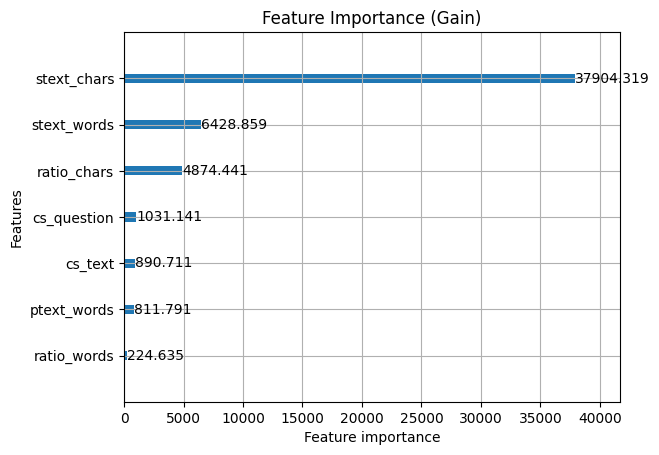

In [28]:
plt.figure(figsize=(10, 6))
lgb.plot_importance(model_dict["content"][0], importance_type='gain', max_num_features=10) # You can change 'gain' to 'split' if needed
plt.title("Feature Importance (Gain)")
plt.show()